# 헬멧 착용여부 파악

In [57]:
import os
import random
import shutil
from tqdm.notebook import tqdm
import cv2
import glob
import json

%matplotlib inline

# 데이터 분할

In [2]:
origin_data_root = '/Users/kimhongseok/cv_79_projects/part2/21/origin_data'
data_root = '/Users/kimhongseok/cv_79_projects/part2/21/data'

train_root = os.path.join(data_root, 'train')
valid_root = os.path.join(data_root, 'valid')
test_root = os.path.join(data_root, 'test')

for folder in [train_root, valid_root, test_root]:
    if not os.path.exists(folder):
        os.makedirs(folder)

        for s in ['images', 'labels']:
            s_folder = os.path.join(folder, s)
            if not os.path.exists(s_folder):
                os.makedirs(s_folder)

In [3]:
img_list = glob.glob(f'{origin_data_root}/images/*.png')
annot_list = glob.glob(f'{origin_data_root}/annotations/*.xml')
print(len(img_list), len(annot_list))

5000 5000


In [4]:
# xml -> yolo

def xml_to_yolo_bbox(bbox, w, h):
    x_center = ((bbox[2] + bbox[0])/2)/w
    y_center = ((bbox[3] + bbox[1])/2)/h
    width = (bbox[2] - bbox[0])/w
    height = (bbox[3] - bbox[1])/h
    
    return [x_center, y_center, width, height]

In [5]:
import xml.etree.ElementTree as ET

classes = []
for file in tqdm(img_list):
    file_name = file.split('/')[-1].replace('png', 'xml')
    save_name = file_name.replace('xml', 'txt')
    file_path = f'{origin_data_root}/annotations/{file_name}'
    save_path = f'{origin_data_root}/labels/{save_name}'

    result = list()
    tree = ET.parse(file_path)
    root = tree.getroot()
    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)
    for obj in root.findall('object'):
        label = obj.find('name').text
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find('bndbox')]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        bbox_string = ' '.join([str(x) for x in yolo_bbox])
        result.append(f'{index} {bbox_string}')

    if result:
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(result))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [6]:
random.seed(2024)
random.shuffle(img_list)
test_ratio = 0.1
num_file = len(img_list)

test_list = img_list[:int(num_file*test_ratio)]
valid_list = img_list[int(num_file*test_ratio):int(num_file*test_ratio)*2]
train_list = img_list[int(num_file*test_ratio)*2:]

for i in test_list:
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'{origin_data_root}/labels/{label_name}'
    shutil.copyfile(label_path, f'{test_root}/labels/{label_name}')
    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{test_root}/images/{img_name}')

for i in valid_list:
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'{origin_data_root}/labels/{label_name}'
    shutil.copyfile(label_path, f'{valid_root}/labels/{label_name}')
    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{valid_root}/images/{img_name}')

for i in train_list:
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'{origin_data_root}/labels/{label_name}'
    shutil.copyfile(label_path, f'{train_root}/labels/{label_name}')
    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{train_root}/images/{img_name}')

In [7]:
classes

['helmet', 'head', 'person']

# config 파일 생성

In [8]:
pjt_root = '/Users/kimhongseok/cv_79_projects/part2/21'

In [9]:
import yaml
data = dict()

data['train'] = train_root
data['val'] = valid_root
data['test'] = test_root
data['nc'] = len(classes)
data['names'] = classes

with open(f'{pjt_root}/safety_helmet.yaml', 'w') as f:
    yaml.dump(data, f)

# training

In [10]:
import ultralytics
from ultralytics import YOLO

In [11]:
%cd /Users/kimhongseok/cv_79_projects/part2/21

/Users/kimhongseok/cv_79_projects/part2/21


In [14]:
model = YOLO('yolov8s.pt').to('mps')
result = model.train(data='safety_helmet.yaml', epochs=1, batch=8, imgsz=224, name='safety_n')

New https://pypi.org/project/ultralytics/8.2.91 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=safety_helmet.yaml, epochs=1, time=None, patience=100, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=mps:0, workers=8, project=None, name=safety_n4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning /Users/kimhongseok/cv_79_projects/part2/21/data/train/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/kimhongseok/cv_79_projects/part2/21/data/valid/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]

Plotting labels to runs/detect/safety_n4/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/detect/safety_n4
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      2.056      2.736      1.309         45        224:  14%|█▍        | 72/500 [02:01<12:04,  1.69s/it]


KeyboardInterrupt: 

# test

In [14]:
model = YOLO('/Users/kimhongseok/cv_79_projects/part2/21/runs/detect/safety_n/weights/best.pt')
metrics = model.val(split='test')

print('map50-95', metrics.box.map)
print('map50', metrics.box.map50)

Ultralytics YOLOv8.2.66 🚀 Python-3.11.7 torch-2.3.0 CPU (Apple M1 Pro)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /Users/kimhongseok/cv_79_projects/part2/21/data/test/labels... 500 images, 0 backgrounds, 423 corrupt: 100%|██████████| 500/500 [00:00<00:00, 1127.43it/s]

val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/21/data/test/images/hard_hat_workers10.png: ignoring corrupt image/label: could not convert string to float: '0.11538461538461539/n0'
val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/21/data/test/images/hard_hat_workers1050.png: ignoring corrupt image/label: could not convert string to float: '0.2216867469879518/n0'
val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/21/data/test/images/hard_hat_workers1053.png: ignoring corrupt image/label: could not convert string to float: '0.2385542168674699/n0'
val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/21/data/test/images/hard_hat_workers1064.png: ignoring corrupt image/label: could not convert string to float: '0.09397590361445783/n0'
val: WARNING ⚠️ /Users/kimhongseok/cv_79_projects/part2/21/data/test/images/hard_hat_workers1072.png: ignoring corrupt image/label: could not convert string to float: '0.2283653846153846/n0'
val: WARNING ⚠️ /Users/kimhongseok/cv_79_proj


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


                   all         77         77      0.835      0.693      0.733      0.499
                helmet         72         72      0.711      0.986      0.956      0.645
                  head          5          5       0.96        0.4       0.51      0.352
Speed: 0.2ms preprocess, 67.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val
map50-95 0.49890367861278523
map50 0.7327034279198288


# inference

In [15]:
from PIL import Image
import torchvision.transforms as T

test_file_list = glob.glob(f'{test_root}/images/*')
random.shuffle(test_file_list)

model = YOLO('/Users/kimhongseok/cv_79_projects/part2/21/runs/detect/safety_n/weights/best.pt')

test_data_transforms = T.Compose([
    T.ToTensor()
])

color_dict = [[random.randint(0, 255) for _ in range(3)] for _ in range(0, len(model.names))]

In [19]:
test_img = cv2.imread(test_file_list[0])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
results = model(img_src)


0: 224x224 2 helmets, 34.5ms
Speed: 2.0ms preprocess, 34.5ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 224)


In [20]:
print(results[0].boxes)

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0.])
conf: tensor([0.7094, 0.6372])
data: tensor([[123.9567, 111.1357, 160.6475, 145.1347,   0.7094,   0.0000],
        [224.0774, 113.9239, 254.9681, 148.7065,   0.6372,   0.0000]])
id: None
is_track: False
orig_shape: (416, 416)
shape: torch.Size([2, 6])
xywh: tensor([[142.3021, 128.1352,  36.6908,  33.9990],
        [239.5227, 131.3152,  30.8907,  34.7825]])
xywhn: tensor([[0.3421, 0.3080, 0.0882, 0.0817],
        [0.5758, 0.3157, 0.0743, 0.0836]])
xyxy: tensor([[123.9567, 111.1357, 160.6475, 145.1347],
        [224.0774, 113.9239, 254.9681, 148.7065]])
xyxyn: tensor([[0.2980, 0.2672, 0.3862, 0.3489],
        [0.5386, 0.2739, 0.6129, 0.3575]])


In [36]:
color_dict[0]

[124, 76, 159]


0: 224x224 1 helmet, 38.1ms
Speed: 0.8ms preprocess, 38.1ms inference, 0.3ms postprocess per image at shape (1, 3, 224, 224)


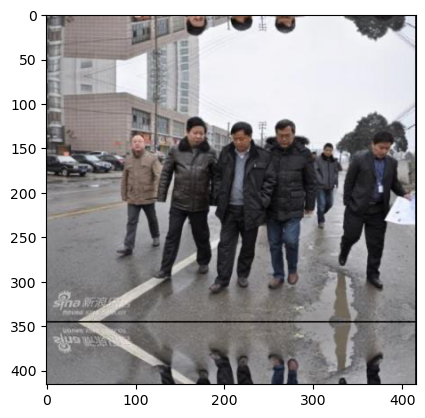

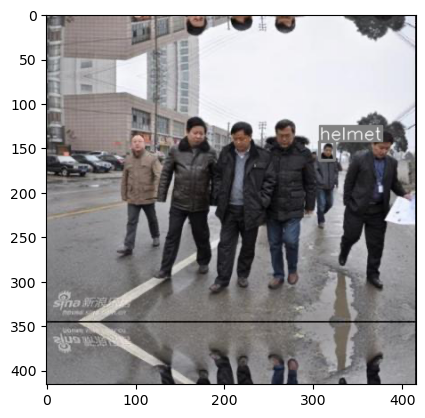

In [58]:
from ultralytics.utils.plotting import Annotator
import matplotlib.pyplot as plt

num_head = 0

test_img = cv2.imread(test_file_list[10])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)[0]

plt.imshow(img_src)
plt.show()

annotator = Annotator(img_src)
boxes = result.boxes
for box in boxes:
    b = box.xyxy[0]
    cls = box.cls
    if 'Head' == model.names[int(cls)]:
        num_head+=1
    annotator.box_label(b.tolist(), model.names[int(cls)])

img_src = annotator.result()

if num_head > 0:
    cv2.rectangle(img_src, (0, 0), (300, 100), (255, 0, 0), -1, cv2.LINE_AA)
    cv2.putText(img_src, '!No Hard Helmet!', (5, 70), cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 255), thickness=3, lineType=cv2.LIN_AA)

plt.imshow(img_src)
plt.show()